In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed, ConfusionMatrix
from sklearn.metrics import matthews_corrcoef, mean_squared_error

c:\Users\vibal\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pretty(ld, indent=0):
    return None
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_mcc'
metric_filter_2 = 'test_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.08, 0.02, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

In [7]:
(dataset[0].ndata['train_mask']).sum()

tensor(115)

In [8]:
(dataset[0].ndata['val_mask']).sum()

tensor(28)

In [9]:
(dataset[0].ndata['test_mask']).sum()

tensor(1301)

## Baseline

In [10]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [11]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [12]:
x_train.shape

torch.Size([143, 4])

In [13]:
x_test.shape

torch.Size([1301, 4])

### Logistic Regression

In [14]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.41      0.75      0.53       325
           1       0.48      0.03      0.07       315
           2       0.38      0.69      0.49       328
           3       0.92      0.24      0.38       333

    accuracy                           0.43      1301
   macro avg       0.55      0.43      0.37      1301
weighted avg       0.55      0.43      0.37      1301



In [15]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.3916083916083916
Test accuracy: 0.4304381245196003
Train rmse: 1.220455033792925
Test rmse: 1.2267828482671495
Train mcc: 0.23639868353224477
Test mcc: 0.2727701056180908


### Random Forest

In [16]:
# # x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
# x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
# y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]
x_train_rf = x_train
y_train_rf = y_train
x_val_rf = x_test
y_val_rf = y_test

In [17]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = matthews_corrcoef(y_true=y_val_rf,y_pred=tmp.predict(x_val_rf))
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 21/21 [00:01<00:00, 14.28it/s]

              precision    recall  f1-score   support

           0       0.53      0.49      0.51       325
           1       0.43      0.53      0.48       315
           2       0.67      0.46      0.54       328
           3       0.76      0.87      0.81       333

    accuracy                           0.59      1301
   macro avg       0.60      0.59      0.58      1301
weighted avg       0.60      0.59      0.59      1301



In [18]:
model_rf

RandomForestClassifier(n_estimators=78, random_state=4444)

In [19]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 1.0
Val accuracy: 0.5903151421983089
Test accuracy: 0.5903151421983089
Train rmse: 0.0
Val rmse: 0.9946049702706146
Test rmse: 0.9946049702706146
Train mcc: 1.0
Val mcc: 0.45748378551900787
Test mcc: 0.45748378551900787


In [20]:
from models.utils import load_pickle, ClassConfusionMatrix, save_pickle
cm = ClassConfusionMatrix(dataset.num_classes, name='test')
cm.add(torch.as_tensor(model_rf.predict(x_test)), torch.as_tensor(y_test), torch.zeros(y_test.shape[0]))
save_pickle(cm, '../../results/eur_rf_10.pkl')

In [19]:
cm_rf = ConfusionMatrix(size=4)
cm_rf.add(preds=torch.as_tensor(model_rf.predict(x_test)), labels=torch.as_tensor(y_test))

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

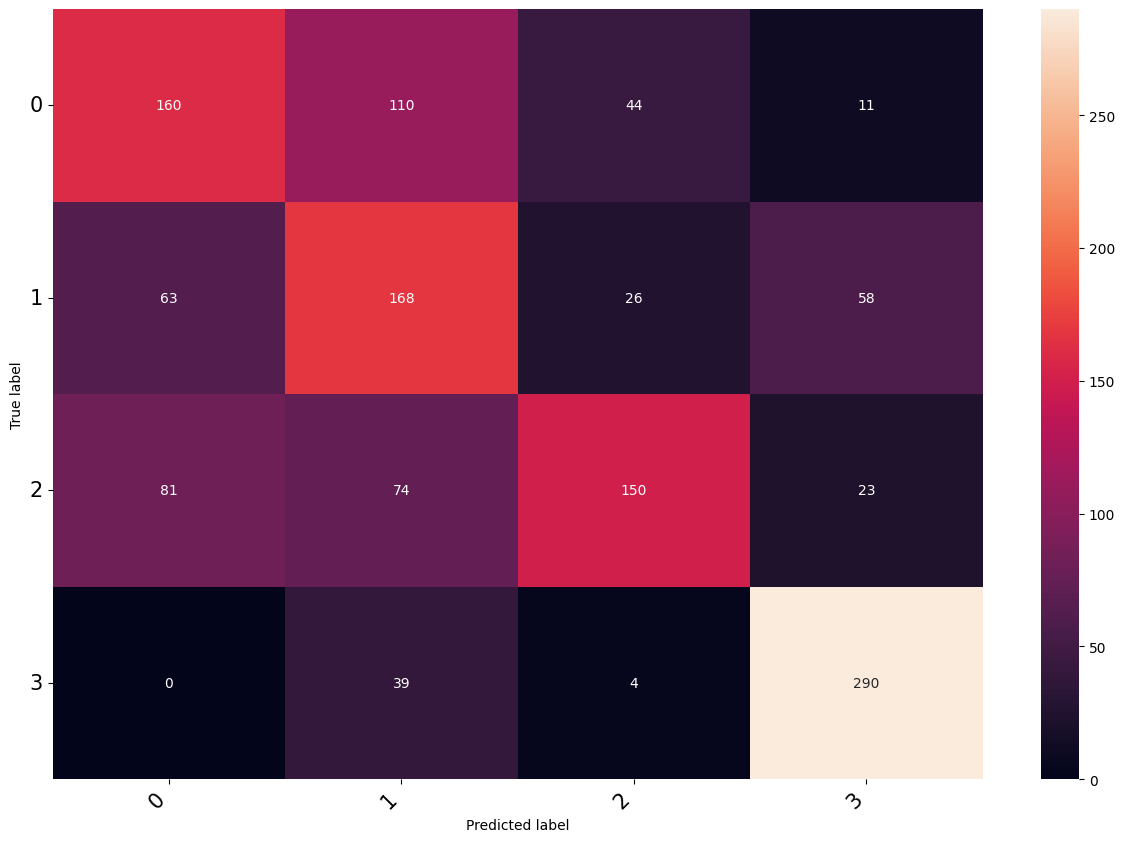

In [20]:
cm_rf.visualize()

In [21]:
cm_rf.class_accuracy

tensor([0.4923, 0.5333, 0.4573, 0.8709])

In [22]:
(cm_rf.labels==0).sum()

tensor(325)

### KNN Classifier

In [23]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.39      0.62      0.48       325
           1       0.35      0.39      0.37       315
           2       0.50      0.18      0.27       328
           3       0.64      0.60      0.62       333

    accuracy                           0.45      1301
   macro avg       0.47      0.45      0.43      1301
weighted avg       0.47      0.45      0.43      1301



In [24]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.6783216783216783
Test accuracy: 0.44811683320522677
Train rmse: 0.9894548898363074
Test rmse: 1.3054017731690022
Train mcc: 0.5795907202882516
Test mcc: 0.273664076951933


### FNN

In [25]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[100], [100] * 2, [100] * 3, [200], [200]*2,[200]*3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [26]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
            scheduler_patience=20,
        )

100%|██████████| 72/72 [02:48<00:00,  2.34s/it]


#### Results

In [27]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1032/1032 [00:30<00:00, 33.72it/s]


In [28]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.6046985759004321,
 'epoch': 98,
 'train_loss': 0.9606395,
 'train_acc': 0.7391303777694702,
 'val_acc': 0.7142854928970337,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.71_2023-03-30_03.36.57.539087',
 'train_rmse': 0.7342550202638104,
 'val_rmse': 0.7071067811865476,
 'test_rmse': 0.9583966883000505,
 'train_mae': 0.34782608695652173,
 'val_mae': 0.35714285714285715,
 'test_mae': 0.574173712528824,
 'train_mcc': 0.6511413519413204,
 'test_mcc': 0.46342039089009324,
 'test_acc': 0.5903151631355286,
 'train_rmse_perc': 0.18745607,
 'val_rmse_perc': 0.16295268,
 'test_rmse_perc': 0.24338998,
 'tra

In [29]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.6088505111613877,
 'epoch': 70,
 'train_loss': 0.9763651,
 'train_acc': 0.6521738767623901,
 'val_acc': 0.7142854928970337,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.71_2023-03-30_03.36.18.687057_70',
 'train_rmse': 0.8846517369293828,
 'val_rmse': 0.8864052604279183,
 'test_rmse': 1.135006526644899,
 'train_mae': 0.48695652173913045,
 'val_mae': 0.42857142857142855,
 'test_mae': 0.7194465795541891,
 'train_mcc': 0.5390998703625527,
 'test_mcc': 0.3911410642742423,
 'test_acc': 0.5388162732124329,
 'train_rmse_perc': 0.22391914,
 'val_rmse_perc': 0.2081809,
 'test_rmse_perc': 0.28265855,
 'train_m

In [30]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.6046985759004321,
 'epoch': 98,
 'train_loss': 0.9606395,
 'train_acc': 0.7391303777694702,
 'val_acc': 0.7142854928970337,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.71_2023-03-30_03.36.57.539087',
 'train_rmse': 0.7342550202638104,
 'val_rmse': 0.7071067811865476,
 'test_rmse': 0.9583966883000505,
 'train_mae': 0.34782608695652173,
 'val_mae': 0.35714285714285715,
 'test_mae': 0.574173712528824,
 'train_mcc': 0.6511413519413204,
 'test_mcc': 0.46342039089009324,
 'test_acc': 0.5903151631355286,
 'train_rmse_perc': 0.18745607,
 'val_rmse_perc': 0.16295268,
 'test_rmse_perc': 0.24338998,
 'tra

In [31]:
pretty([all[k]['dict'] for k in sort_idx])

### Baseline Overall

In [32]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.3916083916083916, 'random_forest': 1.0, 'knn_classifier': 0.6783216783216783}
{'random_forest': 0.5903151421983089}
{'logistic_regression': 0.42736356648731744, 'random_forest': 0.5903151421983089, 'knn_classifier': 0.44811683320522677}


In [33]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.23639868353224477, 'random_forest': 1.0, 'knn_classifier': 0.5795907202882516}
{'random_forest': 0.45748378551900787}
{'logistic_regression': 0.26853648260151697, 'random_forest': 0.45748378551900787, 'knn_classifier': 0.273664076951933}


In [34]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 1.220455033792925, 'random_forest': 0.0, 'knn_classifier': 0.9894548898363074}
{'random_forest': 0.9946049702706146}
{'logistic_regression': 1.2289738131298626, 'random_forest': 0.9946049702706146, 'knn_classifier': 1.3054017731690022}


### GCN

In [35]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     # h_features=[[5, 10], [10, 15], [5], [10], [15], [10,15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0, 0.2, 0.4],
#     use_edge_weight=[True, False],
#     drop_edges=[0,0.2,0.4],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [36]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 144/144 [11:17<00:00,  4.70s/it]


#### Results

In [37]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1774/1774 [01:10<00:00, 25.04it/s]


In [38]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': -0.02122993922420586,
 'epoch': 40,
 'train_loss': 8712.374,
 'train_acc': 0.3739130198955536,
 'val_acc': 0.21428564190864563,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.21_2023-03-30_03.47.07.943569_40',
 'train_rmse': 1.1344410613774214,
 'val_rmse': 1.5118578920369088,
 'test_rmse': 1.459154356932768,
 'train_mae': 0.8347826086956521,
 'val_mae': 1.2142857142857142,
 'test_mae': 1.1083781706379707,
 'train_mcc': 0.19266490515665674,
 'test_mcc': 0.09866305914988445,
 'test_acc': 0.31283628940582275,
 'train_rmse_perc': 0.28500304,
 'val_rmse_perc': 0.369048,
 'test_rmse_

In [39]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3724439919481158,
 'epoch': 1,
 'train_loss': 13223963.0,
 'train_acc': 0.22608694434165955,
 'val_acc': 0.42857128381729126,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.43_2023-03-30_03.49.36.913697',
 'train_rmse': 1.318760946791574,
 'val_rmse': 0.944911182523068,
 'test_rmse': 1.2920855279468124,
 'train_mae': 1.0782608695652174,
 'val_mae': 0.6785714285714286,
 'test_mae': 1.0438124519600307,
 'train_mcc': -0.030258952441096047,
 'test_mcc': -0.015095280339727625,
 'test_acc': 0.24519599974155426,
 'train_rmse_perc': 0.3341579,
 'val_rmse_perc': 0.23287797,
 'test_rmse

In [40]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': -0.02122993922420586,
 'epoch': 40,
 'train_loss': 8712.374,
 'train_acc': 0.3739130198955536,
 'val_acc': 0.21428564190864563,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.21_2023-03-30_03.47.07.943569_40',
 'train_rmse': 1.1344410613774214,
 'val_rmse': 1.5118578920369088,
 'test_rmse': 1.459154356932768,
 'train_mae': 0.8347826086956521,
 'val_mae': 1.2142857142857142,
 'test_mae': 1.1083781706379707,
 'train_mcc': 0.19266490515665674,
 'test_mcc': 0.09866305914988445,
 'test_acc': 0.31283628940582275,
 'train_rmse_perc': 0.28500304,
 'val_rmse_perc': 0.369048,
 'test_rmse_

In [41]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [42]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
#     out_features = [out_feats],
#     # aggregator_type = ['mean', 'lstm'],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0, 0.2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features=[[200]*2],
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.0],
    # other
    lr=[1e-2],
    label_smoothing=[0],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [43]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=1000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=100,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
            scheduler_patience=500,
        )

100%|██████████| 1/1 [08:41<00:00, 521.86s/it]


#### Results

In [44]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 16/16 [00:05<00:00,  2.92it/s]


In [45]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [200, 200],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 500,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5340712676440015,
 'epoch': 600,
 'train_loss': 0.06910671,
 'train_acc': 0.9826086163520813,
 'val_acc': 0.6428568959236145,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.64_2023-03-30_03.51.23.524285_600',
 'train_rmse': 0.1318760946791574,
 'val_rmse': 1.0350983390135313,
 'test_rmse': 1.2164008603400962,
 'train_mae': 0.017391304347826087,
 'val_mae': 0.5714285714285714,
 'test_mae': 0.7186779400461184,
 'train_mcc': 0.9766307661044503,
 'test_mcc': 0.46020019134318213,
 'test_acc': 0.5941583514213562,
 'train_rmse_perc': 0.078356765,
 'val_rmse

In [46]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 500,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7312184894500596,
 'epoch': 220,
 'train_loss': 0.27107129,
 'train_acc': 0.8695651888847351,
 'val_acc': 0.7857140302658081,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.79_2023-03-30_03.51.23.524285',
 'train_rmse': 0.659380473395787,
 'val_rmse': 0.944911182523068,
 'test_rmse': 1.3133267133926287,
 'train_mae': 0.22608695652173913,
 'val_mae': 0.39285714285714285,
 'test_mae': 0.8332052267486548,
 'train_mcc': 0.8331784453556204,
 'test_mcc': 0.39121713071336267,
 'test_acc': 0.5334358215332031,
 'train_rmse_perc': 0.18453407,
 'val_rmse_perc':

In [47]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0,
 'tr_par_use_edge_weight': True,
 'tr_par_scheduler_patience': 500,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5340712676440015,
 'epoch': 600,
 'train_loss': 0.06910671,
 'train_acc': 0.9826086163520813,
 'val_acc': 0.6428568959236145,
 'model_class': 'sage',
 'path_name': 'saved_sage\\0.64_2023-03-30_03.51.23.524285_600',
 'train_rmse': 0.1318760946791574,
 'val_rmse': 1.0350983390135313,
 'test_rmse': 1.2164008603400962,
 'train_mae': 0.017391304347826087,
 'val_mae': 0.5714285714285714,
 'test_mae': 0.7186779400461184,
 'train_mcc': 0.9766307661044503,
 'test_mcc': 0.46020019134318213,
 'test_acc': 0.5941583514213562,
 'train_rmse_perc': 0.078356765,
 'val_rmse

In [48]:
pretty([all[k]['dict'] for k in sort_idx])

#### cm

In [49]:
cm = all[sort_idx[0]]['test_cm'][0]

In [50]:
(cm.labels==0).sum()

tensor(325)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

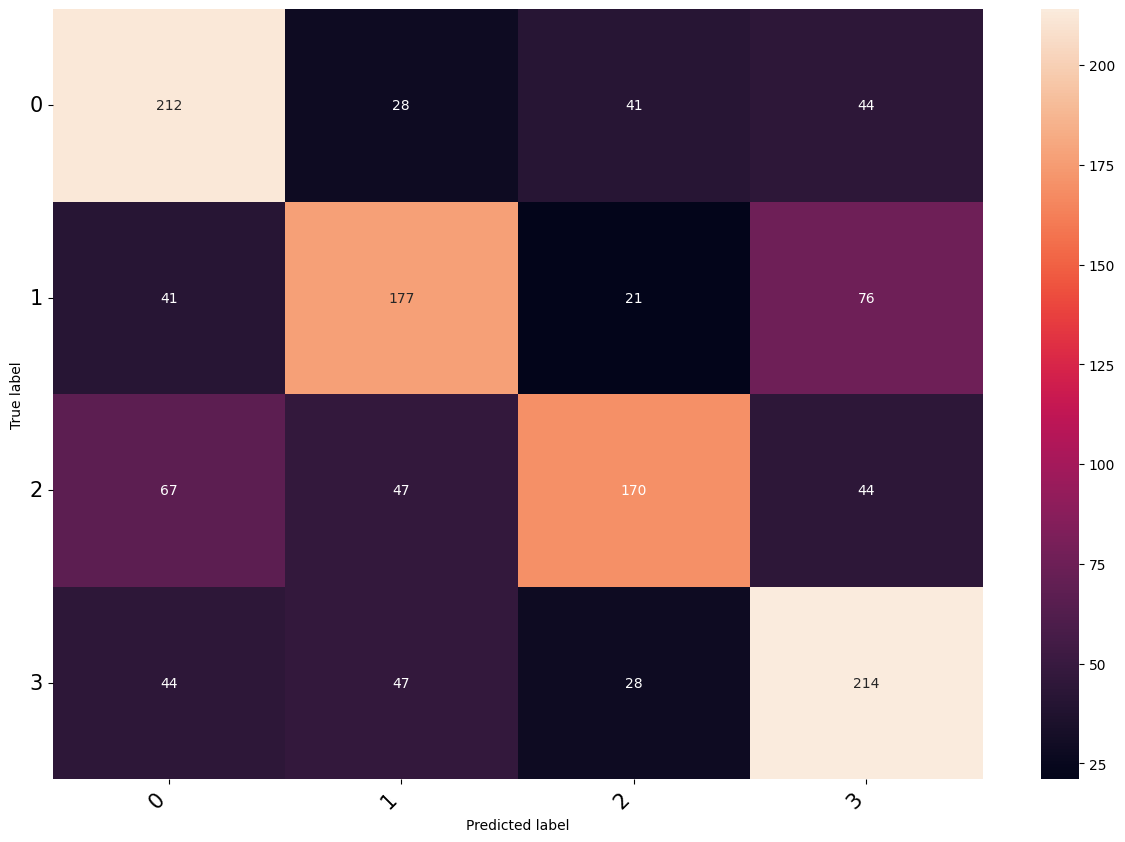

In [51]:
cm.visualize()

In [52]:
cm.class_accuracy

tensor([0.6523, 0.5619, 0.5183, 0.6426])

### GAT

In [53]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 240/240 [25:10<00:00,  6.30s/it]


#### Results

In [55]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 3287/3287 [02:54<00:00, 18.79it/s]


In [56]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.27130478155775545,
 'epoch': 90,
 'train_loss': 1.3531346,
 'train_acc': 0.5304347276687622,
 'val_acc': 0.46428555250167847,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.46_2023-03-30_04.18.17.132941_90',
 'train_rmse': 1.3448775602908665,
 'val_rmse': 1.4880476182856899,
 'test_rmse': 1.5149777460739,
 'train_mae': 0.8347826086956521,
 'val_mae': 1.0,
 'test_mae': 1.0176787086856265,
 'train_mcc': 0.3738448265887705,
 'test_mcc': 0.3190424886983223,
 'test_acc': 0.46810147166252136,
 'train_rmse_perc': 0.3456698,
 'va

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.2,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.4603968266907783,
 'epoch': 44,
 'train_loss': 1.3928218,
 'train_acc': 0.43478259444236755,
 'val_acc': 0.6071426272392273,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.61_2023-03-30_04.08.44.288283',
 'train_rmse': 1.4416174491054197,
 'val_rmse': 1.1801936887041646,
 'test_rmse': 1.5035188037520422,
 'train_mae': 1.0,
 'val_mae': 0.6785714285714286,
 'test_mae': 1.1091468101460416,
 'train_mcc': 0.2320344660091318,
 'test_mcc': 0.16198260789514415,
 'test_acc': 0.3627978563308716,
 'train_rmse_perc': 0.37020645,
 'va

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_label_smoothing': 0.0,
 'tr_par_use_edge_weight': False,
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.27130478155775545,
 'epoch': 90,
 'train_loss': 1.3531346,
 'train_acc': 0.5304347276687622,
 'val_acc': 0.46428555250167847,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.46_2023-03-30_04.18.17.132941_90',
 'train_rmse': 1.3448775602908665,
 'val_rmse': 1.4880476182856899,
 'test_rmse': 1.5149777460739,
 'train_mae': 0.8347826086956521,
 'val_mae': 1.0,
 'test_mae': 1.0176787086856265,
 'train_mcc': 0.3738448265887705,
 'test_mcc': 0.3190424886983223,
 'test_acc': 0.46810147166252136,
 'train_rmse_perc': 0.3456698,
 'va

In [59]:
pretty([all[k]['dict'] for k in sort_idx])